# Linear Disciminant Analysis and Constrained Optimization

Content:

* FDA (2 classes)
    * Compute the class means (in PCA space)
    * Compute the within-class scatter matrix $\mathbf{S}_W$ and between-class scatter matrix $\mathbf{S}_B$
    * Compute the projection vector $\mathbf{w}$
    * Compute and plot the 1D projection of the data
    * Compute the class separation of the projected values
* LDA (3 classes)
    * Compute the within-class scatter matrix $\mathbf{S}_W$ and between-class scatter matrix $\mathbf{S}_B$
    * Compute the projection matrix $\mathbf{W}$
    * Compute and plot the 2D projection of the data
    * Compute the 2D LDA projection of the original 64D data 
* Constrained Optimization
    * Reformulate the problem as a maximization problem
    * Write out the Lagrangian function
    * Compute the gradients with respects to $x_1, x_2$, Lagrange multiplier $\lambda$ and the KKT multiplier $\mu$
    * Compute the optimum

In [2]:
# Dependencies
import numpy as np
import scipy
from sklearn.datasets import load_digits, make_swiss_roll
from sklearn.decomposition import PCA 
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns; sns.set(); sns.set_palette('bright')

## Data
We'll be working with a dataset of handwritten digits. 
Let visualise some examples.

In [3]:
# We're using a subset of two classes for now
digits = load_digits(n_class=2)

In [4]:
# Handy plotting functions

def plot_examples():
    show_num = 4
    _, axes = plt.subplots(1, show_num)
    images_and_labels = list(zip(digits.images, digits.target))
    for ax, (image, label) in zip(axes[:], images_and_labels[:show_num]):
        ax.set_axis_off()
        ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
        ax.set_title('Label: %i' % label)

def plot_scatter(data, target, alpha=0.5, legend=True):
    scatter = plt.scatter(data[:, 0], data[:, 1], c=target, edgecolor='none', alpha=alpha, cmap='rainbow')
    if legend:
        plt.legend(*scatter.legend_elements(), loc="upper right", title="Targets")
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    
def plot_scatter3d(data, targets, view_point=(25, 45), alpha=0.5, legend=True):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(data[:,0], data[:,1], data[:,2], c=targets, cmap="rainbow", alpha=alpha)
    if legend:
        plt.legend(*scatter.legend_elements(), loc="upper right", title="Targets")
    ax.view_init(*view_point) # <- change viewpoint here
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    plt.show()

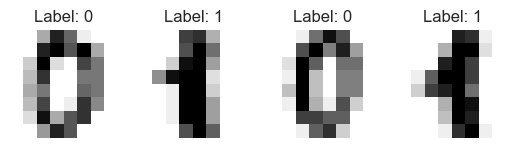

In [5]:
plot_examples()

In [6]:
# We can get a 2D version of the data using PCA
pca = PCA(n_components=2)
X = pca.fit_transform(digits.data) # this is the representation, we'll be working with
t = digits.target
X
t

array([0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,

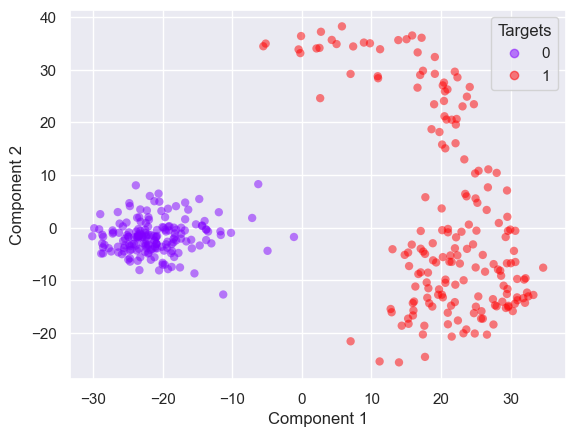

In [7]:
# Let's plot all the data in 2D
plot_scatter(X, t)

## 1) Fisher Discriminant Analysis (FDA)


### 1.1) Compute the class means (in PCA space)

In [8]:
X1 = X[t == 0]
X2 = X[t == 1]
m1 = np.mean(X1, axis=0)
m2 = np.mean(X2, axis=0)

### 1.2) Compute the within-class scatter matrix $\mathbf{S}_W$ and between-class scatter matrix $\mathbf{S}_B$

In [9]:
S_B = np.outer(m2 - m1, m2 - m1)

S_W= np.zeros((2,2))

for x in X1:
   
    S_W += np.outer(x - m1, x - m1)
    
for x in X2:
    S_W += np.outer(x - m2, x - m2)

print("Between-class scatter matrix S_B:")
print(S_B)
print("Within-class scatter matrix S_W:")
print(S_W)



Between-class scatter matrix S_B:
[[1749.26597493  145.05383207]
 [ 145.05383207   12.02825328]]
Within-class scatter matrix S_W:
[[ 15041.33444706 -13053.23317691]
 [-13053.23317691  64127.63085988]]


### 1.3) Compute the projection vector $\mathbf{w}$
We can use `np.linalg.pinv` and `np.linalg.eig` for computing the pseudo-inverse and eigenvectors, respectively.
Also, remember to ensure that $||w||_2 = 1$.

In [10]:
W_unscaled = np.linalg.pinv(S_W) @ (m2-m1)
W = W_unscaled/np.linalg.norm(W_unscaled)

### 1.4) Compute and plot the 1D projection of the data
Useing `seaborn.displot` for a nice visualisation.

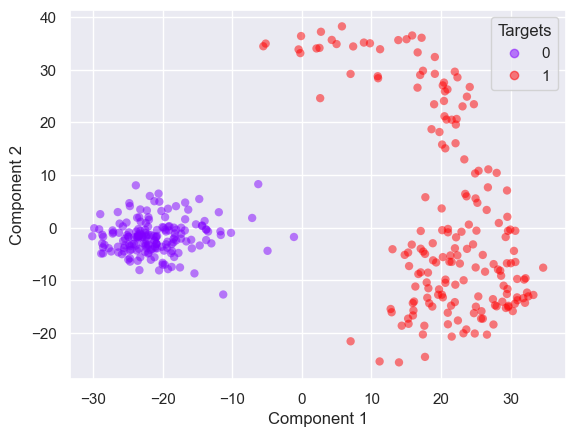

In [29]:
X_proj = np.array([W.T @ x for x in X1])
plot_scatter(X,t)

### 1.5) Compute the class separation of the projected values

In [32]:
proj1 = W @ X1.T
proj2 = W @ X2.T

mu1 = np.mean(proj1)
mu2 = np.mean(proj2)

print("Separation Score:", abs(mu1-mu2))

Separation Score: 41.596313499803756


## 2) Linear Discriminant Analysis (LDA)

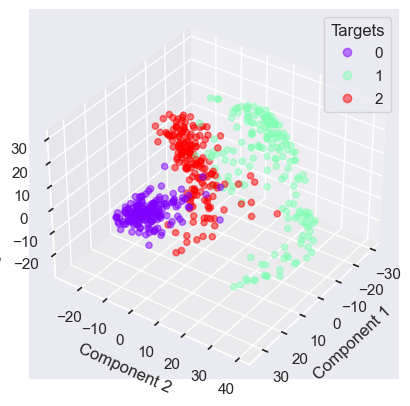

In [12]:
# Data
n_class = 3
digits = load_digits(n_class=n_class)
pca = PCA(n_components=3)
X = pca.fit_transform(digits.data)
t = digits.target

plot_scatter3d(X, t, view_point=(35,35))

### 2.1) Compute the within-class scatter matrix $\mathbf{S}_W$ and between-class scatter matrix $\mathbf{S}_B$

In [13]:
def scatter_matrices(X,t):
    classes = np.unique(t)
    num_features = X.shape[1]
    
    m = np.mean(X, axis=0)
    
    S_B = np.zeros((num_features, num_features))
    S_W = np.zeros((num_features, num_features))
    
    for k in classes:
        X_k = np.array([x for i, x in enumerate(X) if t[i] == k])
        
        m_k = np.mean(X_k, axis=0)
        N_k = X_k.shape[0]
        
        S_B += N_k * np.outer(m_k - m, m_k - m)
        
        for x in X_k:
            S_W += np.outer(x - m_k, x - m_k)
    return S_W, S_B

S_W, S_B = scatter_matrices(X,t)
print("scatter matrix S_B:")
print(S_B)
print("scatter matrix S_W:")
print(S_W)

scatter matrix S_B:
[[168102.96379921 -19720.58430752  19025.65789768]
 [-19720.58430752  63939.56119478  18774.45497557]
 [ 19025.65789768  18774.45497557   9313.72194702]]
scatter matrix S_W:
[[ 27768.47732292  19720.58430752 -19025.65789768]
 [ 19720.58430752  51486.18363445 -18774.45497557]
 [-19025.65789768 -18774.45497557  56959.24515257]]


### 2.2) Compute the projection matrix $\mathbf{W}$

In [14]:
def projection_matrix(X, S_W, S_B, n_class):
    eigenvalues, eigenvectors = np.linalg.eig(np.linalg.pinv(S_W)@S_B)
    biggest_eigvec = np.argsort(-eigenvalues)[:n_class-1]
    W = eigenvectors[:, biggest_eigvec]
    return W


### 2.3) Compute and plot the 2D projection of the data

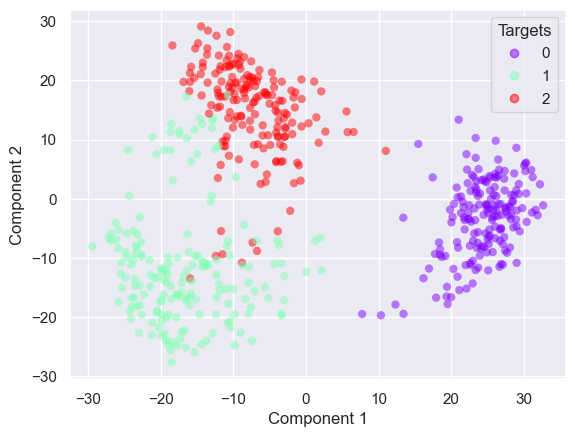

In [15]:
def projection_data(X,W):
    X_proj = np.array([W.T @ x for x in X])
    return X_proj

W = projection_matrix(X, S_W, S_B, n_class)
X_proj = projection_data(X,W)
plot_scatter(X_proj, t)

### 2.4) Compute and plot the 2D LDA projection of the original 64D data 

In [16]:
# Data
n_class = 3
digits = load_digits(n_class=n_class)
X = digits.data
t = digits.target

C:\Users\matti\miniconda3\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\matti\miniconda3\Lib\site-packages\matplotlib\collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


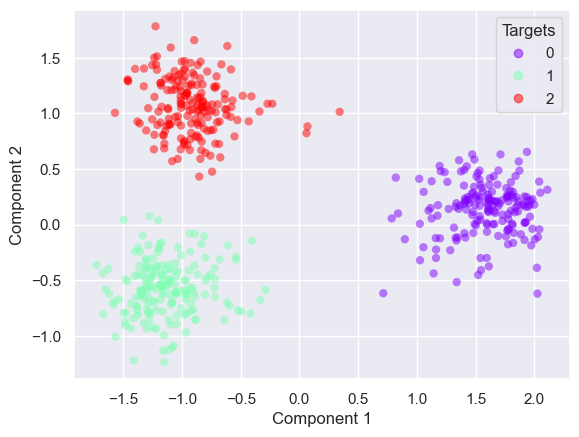

In [17]:
S_W, S_B = scatter_matrices(X,t)
W = projection_matrix(X, S_W, S_B, n_class)
X_proj = projection_data(X,W)
plot_scatter(X_proj, t)

Comment on the general utility of the projection as compared to PCA

LDA: The primary goal of LDA is to maximize the separability between different classes. It is about finding the direction that maximizes the distance between the means of different classes while minimizing the variance within each class.
PCA: PCA, on the other hand, is unsupervised and aims to reduce the dimensionality of the data by capturing the maximum variance in the data. It doesn't consider any class labels.

# 3) Constrained Optimization
 
Consider the problem

minimize $f_{min}(x_1, x_2)$

subject to $ x_1 + x_2 \leq 4 
\quad \text{ and } \quad x_1 + 4x_2 = 5 
$
where $f_{min}(x_1, x_2) = (x_1 - 3)^2 + (x_2 - 2)^2$

## 3.1) Canonical maximization problem


The canonical maximazation problem is where $f_{max}(x_1,x_2) = -f_{min}(x_1,x_2)$, $g(x_1,x_2) = x_1 + 4x_2 -5$, $h(x_1,x_2)=x_1+x_2-4$, and $\mu h(x_1,x_2) = 0$ with inequality constraint $\mu \geq 0$.

## 3.2) Lagrangian function
_Use Equation (E.12) in "Pattern Recognition and Machine Learning" Appendix E., and write out all variables_

$$
L(x_1,x_2, \lambda, \mu) = f_{max}(x_1,x_2)+\lambda g(x_1,x_2)+\mu g(x_1,x_2) = -((x_1-3)^2 + (x_2-2)^2) + \lambda(x_1+4x_2-5) - \mu(x_1+x_2-4)
$$

## 3.3) Gradients with respects to $x_1, x_2$, lagrange multiplier $\lambda$ and the KKT multiplier $\mu$

$$
\nabla \mathcal{L} =  \left[ \frac{\partial \mathcal{L}}{\partial x_1}, \frac{\partial \mathcal{L}}{\partial x_2}, \frac{\partial \mathcal{L}}{\partial \lambda}, \frac{\partial \mathcal{L}}{\partial \mu} \right] = \left[ -2(x_1-3)+\lambda-\mu, -2(x_2-2)+4\lambda-\mu, x_1+4x_2-5, -x_1-x_2+4 \right]
$$

## 3.4) Compute the optimum
We set up as a system of linear equations and solve it using Gaussian Elimination (e.g. using `scipy.linalg.solve`).

In [18]:
# Inequality constraint is binding (x1 + x2 = 4)
A1 = np.array([
    [-2, 0, 1, -1],
    [0, -2, 4, -1],
    [1, 4, 0, 0],
    [-1, -1, 0, 0]
])
b1 = np.array([-6, -4, 5, -4])
sol1 = scipy.linalg.solve(A1, b1)

# Inequality constraint is non-binding (mu = 0)
A2 = np.array([
    [-2, 0, 1],
    [0, -2, 4],
    [1, 4, 0]
])
b2 = np.array([-6, -4, 5,])
sol2 = scipy.linalg.solve(A2, b2)

print("Solution when inequality constraint is binding: ", sol1)
print("Solution when inequality constraint is non-binding: ", sol2)

def f(x1, x2):
    return (x1 - 3)**2 + (x2 - 2)**2

obj1 = f(sol1[0], sol1[1])
obj2 = f(sol2[0], sol2[1])

print(f"Value when inequality constraint is binding: {obj1}")
print(f"Value when inequality constraint is non-binding: {obj2}")



Solution when inequality constraint is binding:  [ 3.66666667  0.33333333 -1.55555556 -2.88888889]
Solution when inequality constraint is non-binding:  [ 2.64705882  0.58823529 -0.70588235]
Value when inequality constraint is binding: 3.222222222222223
Value when inequality constraint is non-binding: 2.117647058823529


We see that the optimal point to minimize $f$ under the given constrains is (2.64705882  0.58823529) which gives a value of 2.117647058823529.